In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


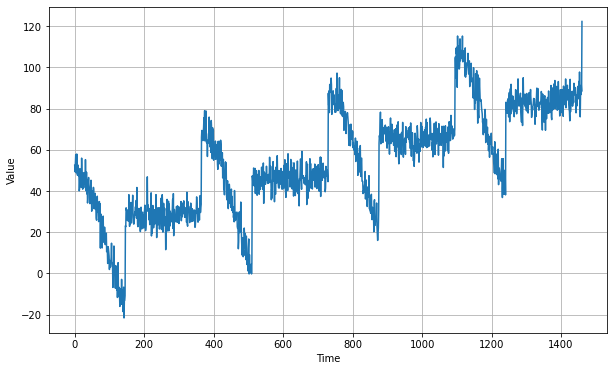

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end])
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
# baseline = 10
# sereis = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [3]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # expand the dimensions of series
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:])) # sequence to sequence
    
    return ds.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), # sequence to sequence
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 55ms/step - loss: 73.1912 - mae: 73.6904
Epoch 2/100
8/8 [==============================] - 0s 48ms/step - loss: 72.4799 - mae: 72.9791
Epoch 3/100
8/8 [==============================] - 0s 48ms/step - loss: 71.3446 - mae: 71.8437
Epoch 4/100
8/8 [==============================] - 0s 52ms/step - loss: 69.9230 - mae: 70.4223
Epoch 5/100
8/8 [==============================] - 0s 51ms/step - loss: 68.2678 - mae: 68.7669
Epoch 6/100
8/8 [==============================] - 0s 54ms/step - loss: 66.3621 - mae: 66.8609
Epoch 7/100
8/8 [==============================] - 0s 53ms/step - loss: 64.2432 - mae: 64.7424
Epoch 8/100
8/8 [==============================] - 0s 55ms/step - loss: 61.8749 - mae: 62.3738
Epoch 9/100
8/8 [==============================] - 0s 56ms/step - loss: 59.2491 - mae: 59.7479
Epoch 10/100
8/8 [==============================] - 0s 53ms/step - loss: 56.3267 - mae: 56.8254
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 1s 68ms/step - loss: 25.7856 - mae: 26.2816
Epoch 88/100
8/8 [==============================] - 1s 64ms/step - loss: 16.4570 - mae: 16.9504
Epoch 89/100
8/8 [==============================] - 0s 58ms/step - loss: 12.7023 - mae: 13.1947
Epoch 90/100
8/8 [==============================] - 0s 62ms/step - loss: 14.0731 - mae: 14.5670
Epoch 91/100
8/8 [==============================] - 0s 59ms/step - loss: 18.5908 - mae: 19.0853
Epoch 92/100
8/8 [==============================] - 0s 58ms/step - loss: 18.7943 - mae: 19.2896
Epoch 93/100
8/8 [==============================] - 0s 60ms/step - loss: 13.0096 - mae: 13.5013
Epoch 94/100
8/8 [==============================] - 0s 58ms/step - loss: 22.7025 - mae: 23.1985
Epoch 95/100
8/8 [==============================] - 0s 60ms/step - loss: 21.5346 - mae: 22.0305
Epoch 96/100
8/8 [==============================] - 0s 62ms/step - loss: 13.3888 - mae: 13.8805
Epoch 97/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

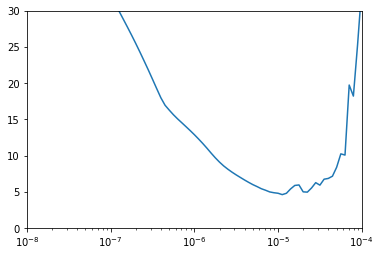

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, None, 1)           65        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________


In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
batch_size= 32
train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
31/31 [==============================] - 1s 33ms/step - loss: 27.3278 - mae: 27.8236
Epoch 2/500
31/31 [==============================] - 1s 30ms/step - loss: 10.4005 - mae: 10.8894
Epoch 3/500
31/31 [==============================] - 1s 30ms/step - loss: 7.7115 - mae: 8.1960
Epoch 4/500
31/31 [==============================] - 1s 29ms/step - loss: 6.8613 - mae: 7.3439
Epoch 5/500
31/31 [==============================] - 1s 30ms/step - loss: 6.3387 - mae: 6.8205
Epoch 6/500
31/31 [==============================] - 1s 29ms/step - loss: 5.9785 - mae: 6.4595
Epoch 7/500
31/31 [==============================] - 1s 28ms/step - loss: 5.6776 - mae: 6.1572
Epoch 8/500
31/31 [==============================] - 1s 29ms/step - loss: 5.5133 - mae: 5.9932
Epoch 9/500
31/31 [==============================] - 1s 27ms/step - loss: 5.3457 - mae: 5.8250
Epoch 10/500
31/31 [==============================] - 1s 28ms/step - loss: 5.2780 - mae: 5.7576
Epoch 11/500
31/31 [=========================

31/31 [==============================] - 1s 23ms/step - loss: 4.2372 - mae: 4.7125
Epoch 87/500
31/31 [==============================] - 1s 26ms/step - loss: 4.2380 - mae: 4.7138
Epoch 88/500
31/31 [==============================] - 1s 24ms/step - loss: 4.2209 - mae: 4.6959
Epoch 89/500
31/31 [==============================] - 1s 24ms/step - loss: 4.2008 - mae: 4.6752
Epoch 90/500
31/31 [==============================] - 1s 23ms/step - loss: 4.2004 - mae: 4.6750
Epoch 91/500
31/31 [==============================] - 1s 24ms/step - loss: 4.2138 - mae: 4.6884
Epoch 92/500
31/31 [==============================] - 1s 23ms/step - loss: 4.2674 - mae: 4.7431
Epoch 93/500
31/31 [==============================] - 1s 23ms/step - loss: 4.1931 - mae: 4.6670
Epoch 94/500
31/31 [==============================] - 1s 23ms/step - loss: 4.1917 - mae: 4.6660
Epoch 95/500
31/31 [==============================] - 1s 24ms/step - loss: 4.2139 - mae: 4.6893
Epoch 96/500
31/31 [==============================] -

31/31 [==============================] - 1s 24ms/step - loss: 4.0937 - mae: 4.5665
Epoch 171/500
31/31 [==============================] - 1s 24ms/step - loss: 4.0821 - mae: 4.5545
Epoch 172/500
31/31 [==============================] - 1s 24ms/step - loss: 4.0911 - mae: 4.5639
Epoch 173/500
31/31 [==============================] - 1s 24ms/step - loss: 4.0792 - mae: 4.5519
Epoch 174/500
31/31 [==============================] - 1s 24ms/step - loss: 4.0859 - mae: 4.5590
Epoch 175/500
31/31 [==============================] - 1s 25ms/step - loss: 4.0979 - mae: 4.5712
Epoch 176/500
31/31 [==============================] - 1s 24ms/step - loss: 4.0847 - mae: 4.5579
Epoch 177/500
31/31 [==============================] - 1s 23ms/step - loss: 4.0837 - mae: 4.5565
Epoch 178/500
31/31 [==============================] - 1s 25ms/step - loss: 4.0955 - mae: 4.5690
Epoch 179/500
31/31 [==============================] - 1s 24ms/step - loss: 4.0932 - mae: 4.5667
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 1s 27ms/step - loss: 4.0118 - mae: 4.4836
Epoch 255/500
31/31 [==============================] - 1s 26ms/step - loss: 4.0116 - mae: 4.4831
Epoch 256/500
31/31 [==============================] - 1s 28ms/step - loss: 4.0130 - mae: 4.4854
Epoch 257/500
31/31 [==============================] - 1s 26ms/step - loss: 4.0237 - mae: 4.4960
Epoch 258/500
31/31 [==============================] - 1s 25ms/step - loss: 4.0614 - mae: 4.5351
Epoch 259/500
31/31 [==============================] - 1s 25ms/step - loss: 4.0227 - mae: 4.4951
Epoch 260/500
31/31 [==============================] - 1s 26ms/step - loss: 4.0154 - mae: 4.4877
Epoch 261/500
31/31 [==============================] - 1s 28ms/step - loss: 4.0475 - mae: 4.5202
Epoch 262/500
31/31 [==============================] - 1s 28ms/step - loss: 4.0223 - mae: 4.4947
Epoch 263/500
31/31 [==============================] - 1s 25ms/step - loss: 4.0215 - mae: 4.4933
Epoch 264/500
31/31 [=======================

31/31 [==============================] - 1s 25ms/step - loss: 3.9949 - mae: 4.4665
Epoch 339/500
31/31 [==============================] - 1s 25ms/step - loss: 3.9605 - mae: 4.4316
Epoch 340/500
31/31 [==============================] - 1s 26ms/step - loss: 3.9663 - mae: 4.4372
Epoch 341/500
31/31 [==============================] - 1s 24ms/step - loss: 3.9621 - mae: 4.4329
Epoch 342/500
31/31 [==============================] - 1s 30ms/step - loss: 3.9544 - mae: 4.4251
Epoch 343/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9526 - mae: 4.4231
Epoch 344/500
31/31 [==============================] - 1s 29ms/step - loss: 3.9810 - mae: 4.4529
Epoch 345/500
31/31 [==============================] - 1s 28ms/step - loss: 3.9579 - mae: 4.4282
Epoch 346/500
31/31 [==============================] - 1s 27ms/step - loss: 3.9852 - mae: 4.4566
Epoch 347/500
31/31 [==============================] - 1s 25ms/step - loss: 3.9688 - mae: 4.4400
Epoch 348/500
31/31 [=======================

31/31 [==============================] - 1s 26ms/step - loss: 3.9247 - mae: 4.3951
Epoch 423/500
31/31 [==============================] - 1s 26ms/step - loss: 3.9382 - mae: 4.4088
Epoch 424/500
31/31 [==============================] - 1s 27ms/step - loss: 3.9068 - mae: 4.3764
Epoch 425/500
31/31 [==============================] - 1s 26ms/step - loss: 3.9681 - mae: 4.4398
Epoch 426/500
31/31 [==============================] - 1s 27ms/step - loss: 3.9506 - mae: 4.4214
Epoch 427/500
31/31 [==============================] - 1s 27ms/step - loss: 3.9396 - mae: 4.4104
Epoch 428/500
31/31 [==============================] - 1s 28ms/step - loss: 3.9121 - mae: 4.3815
Epoch 429/500
31/31 [==============================] - 1s 26ms/step - loss: 3.9003 - mae: 4.3695
Epoch 430/500
31/31 [==============================] - 1s 28ms/step - loss: 3.9025 - mae: 4.3714
Epoch 431/500
31/31 [==============================] - 1s 26ms/step - loss: 3.9054 - mae: 4.3745
Epoch 432/500
31/31 [=======================

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
_________________________________________________________________


In [30]:
for x, y in train_set:
    print(x.numpy().shape)
    print(y.numpy().shape)
    break

(32, 30, 1)
(32, 30, 1)


In [34]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0] # only use last element in the predicted sequences

(1432, 30, 1)


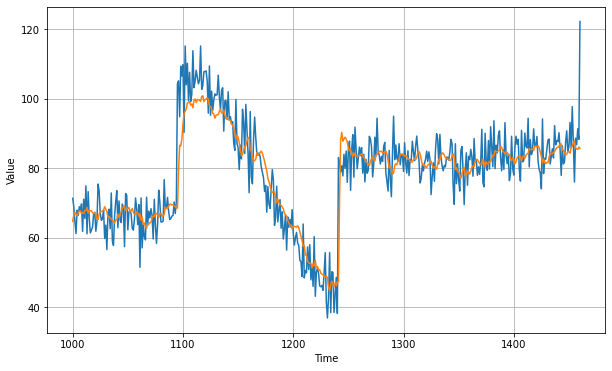

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.848986

<Figure size 432x288 with 0 Axes>

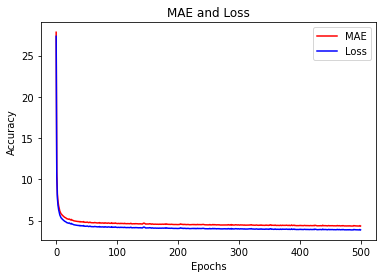

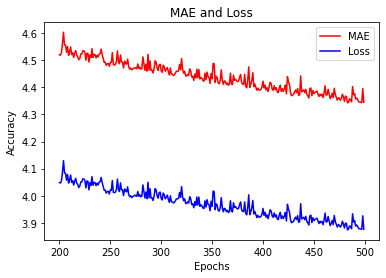

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()